In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_roc(i, fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import mnist
import tensorflow as tf
import contingency_data
import numpy as np
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# number of classes trained on
num_classes = 2
num_adversarial = 10 #how many adversarial examples should be generated (if any) per iteration
num_adversarial_train = 5 # how many iterations for the adversarial

/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.429688
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 1.0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes: 0.99957
Final Accuracy on unexpected data: 0.472796
Final Accuracy on random data: 0.993633


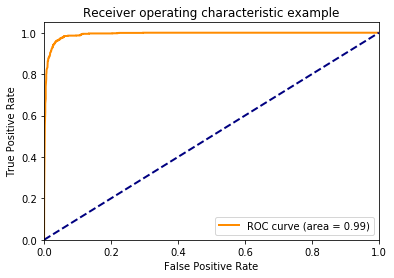

In [4]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withoutContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.429688
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 1.0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes: 0.999226
Final Accuracy on unexpected data: 0.481294
Final Accuracy on random data: 1.0


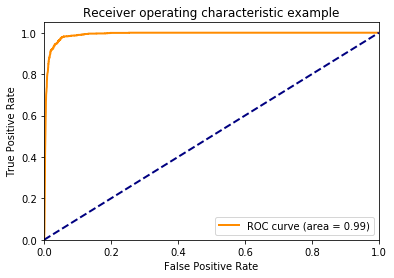

In [16]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withRandomContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

In [6]:
(test_img, test_lbls) = cont_data.next_test_batch(10)
(unexp_img, unexp_lbls) = cont_data.unexpected_data()
unexp_img = unexp_img[:10]
unexp_lbls = unexp_lbls[:10]
with tf.Session() as session:
    (acc_test, pred_test) = session.run(
                    [model['acc_op'], model['pred_op']], 
                    feed_dict={'images:0': test_img, 'labels:0': test_lbls, 'is_training:0': False}
                )
    (acc_unexp, pred_unexp) = session.run(
                    [model['acc_op'], model['pred_op']], 
                    feed_dict={'images:0': unexp_img, 'labels:0': unexp_lbls, 'is_training:0': False}
                )

FailedPreconditionError: Attempting to use uninitialized value ConvNet/out/bias
	 [[Node: ConvNet/out/bias/read = Identity[T=DT_FLOAT, _class=["loc:@ConvNet/out/bias"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](ConvNet/out/bias)]]

Caused by op 'ConvNet/out/bias/read', defined at:
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-6687d77167b9>", line 4, in <module>
    (fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withoutContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
  File "/Users/LeanderK/Documents/ML/contingency/mnist.py", line 113, in run
    model = run_fn(features = images, learning_rate = learning_rate, labels = labels, is_training = is_training)
  File "/Users/LeanderK/Documents/ML/contingency/contingency.py", line 61, in withoutContingency
    , is_training, False)
  File "/Users/LeanderK/Documents/ML/contingency/mnist.py", line 73, in model_fn
    (logits, summaries) = conv_net(features, num_classes, dropout, is_training=is_training, should_reuse=should_reuse)
  File "/Users/LeanderK/Documents/ML/contingency/mnist.py", line 59, in conv_net
    out = tf.layers.dense(fc1, n_classes, name='out')
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 250, in dense
    return layer.apply(inputs)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 559, in __call__
    self.build(input_shapes[0])
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 145, in build
    trainable=True)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 458, in add_variable
    trainable=trainable and self.trainable)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value ConvNet/out/bias
	 [[Node: ConvNet/out/bias/read = Identity[T=DT_FLOAT, _class=["loc:@ConvNet/out/bias"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](ConvNet/out/bias)]]


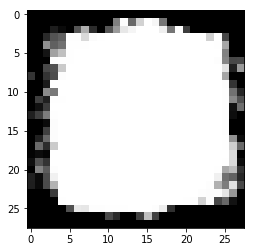

In [13]:
with tf.Session() as session:
    max_im = session.run(mnistCont.max_image)
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(max_im.reshape([28, 28]))

In [ ]:
with tf.Session() as session:
    max_dist = session.run(mnistCont.max_dist)
max_dist

In [22]:
(1-pred[:10,0])

array([  1.48781538e-02,   8.13535213e-01,   2.34544277e-04,
         8.80623698e-01,   7.41061449e-01,   3.75491381e-03,
         1.59448385e-03,   8.23795795e-04,   9.51826572e-04,
         6.31923079e-02], dtype=float32)

In [27]:
from scipy import stats
stats.describe(pred[:200,0])

DescribeResult(nobs=200, minmax=(1.0825846e-05, 0.99999738), mean=0.71061361, variance=0.14342767, skewness=-0.8797718286514282, kurtosis=-0.9394839577699279)

0.0


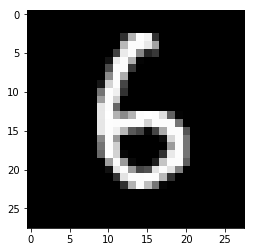

In [8]:
import matplotlib.pyplot as plt
print(cont_data.unexpected_data()[1][10])
plt.gray()
plt.imshow(cont_data.unexpected_data()[0][10].reshape([28, 28]))

In [11]:
cont_data.get_valid_training_data()[0].shape

(11623, 784)